In [1]:
from fastai.vision.all import *
from pytorch_metric_learning import distances, losses, miners, reducers, testers, regularizers, samplers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
DP = True if torch.cuda.device_count() > 1 else False

In [2]:
# set_seed 42
set_seed(42)

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label,
                 item_tfms=Resize(460),
                 batch_tfms=[*aug_transforms(size=(256,256)), Normalize.from_stats(*imagenet_stats)])

loaders = data.dataloaders(untar_data(URLs.IMAGEWOOF_160), bs=120)

In [3]:
classes = len(loaders.vocab)
classes

10

In [4]:
# batch_size must be a multiple of m
# length_before_new_iter >= batch_size must be true
# m * (number of unique labels) >= batch_size must be true
sampler = samplers.MPerClassSampler(loaders.vocab, m=12, batch_size=120, length_before_new_iter=loaders.train.n)
#Fastai 会自动创建一个新的数据加载器，该数据加载器使用相同的数据集，但使用您传递的修改后的关键字参数。
loaders.train = loaders.train.new(shuffle=False, sampler=sampler)

In [5]:
#GeM Pooling可以看作Average Pooling和Max Pooling的延申
#当p=1时，GeM Pooling退化成Average Pooling
#当p无穷大时，GeM pooling 等效于Max Pooling
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class CustomModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head
        self.avgpool = AdaptiveAvgPool((1, 1))
        self.flatten = nn.Flatten()
        self.conv1_1 = nn.Conv2d(2048, 256, 1)
        self.GeM = GeM()
    def VPB(self, x):
        x = torch.chunk(x, 4, dim=3)
        x = [self.avgpool(chunk) for chunk in x]
        x = [self.conv1_1(chunk) for chunk in x]
        x = [self.flatten(chunk) for chunk in x]
        x = torch.cat(x, dim=1)
        return x
    def HPB(self, x):
        x = torch.chunk(x, 4, dim=2)
        x = [self.avgpool(chunk) for chunk in x]
        x = [self.conv1_1(chunk) for chunk in x]
        x = [self.flatten(chunk) for chunk in x]
        x = torch.cat(x, dim=1)
        return x
    def GPB(self, x):
        x = self.GeM(x)
        x = self.flatten(x)
        return x
    def forward(self, x):
        x = self.encoder(x)
        horizontal_embeddings = self.HPB(x)
        vertical_embeddings = self.VPB(x)
        global_embeddings = self.GPB(x)
        classification = self.head(global_embeddings)
        return horizontal_embeddings, vertical_embeddings, global_embeddings, classification

backbone=resnet50(weights="DEFAULT")
backbone.layer4[0].conv2.stride = (1, 1)
backbone.layer4[0].downsample[0].stride = (1, 1)
encoder = create_body(backbone)
head = nn.Sequential(
    nn.BatchNorm1d(2048),
    nn.Linear(2048, classes)
)
#head = create_head(2048, classes, [512, 64], 0.5)
#apply_init(head, nn.init.kaiming_normal_)

model=torch.nn.DataParallel(CustomModel(encoder, head)) if DP else CustomModel(encoder, head)
def siamese_splitter(model):
    return [params(model.module.encoder), params(model.module.head)] if DP else [params(model.encoder), params(model.head)]

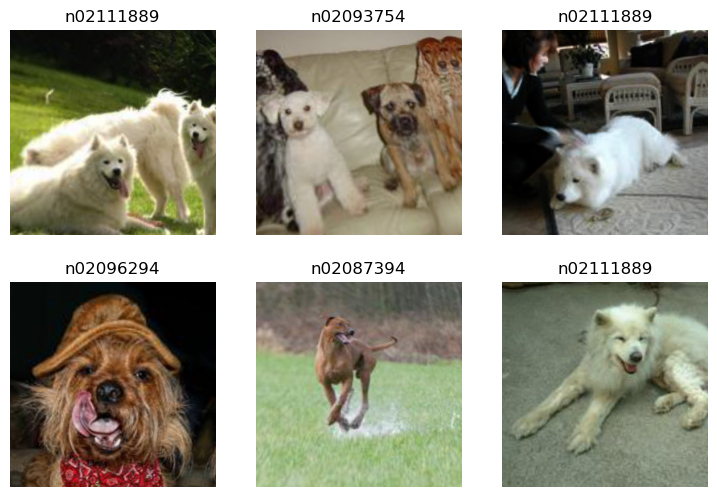

In [6]:
loaders.train.show_batch(max_n=6, nrows=2)

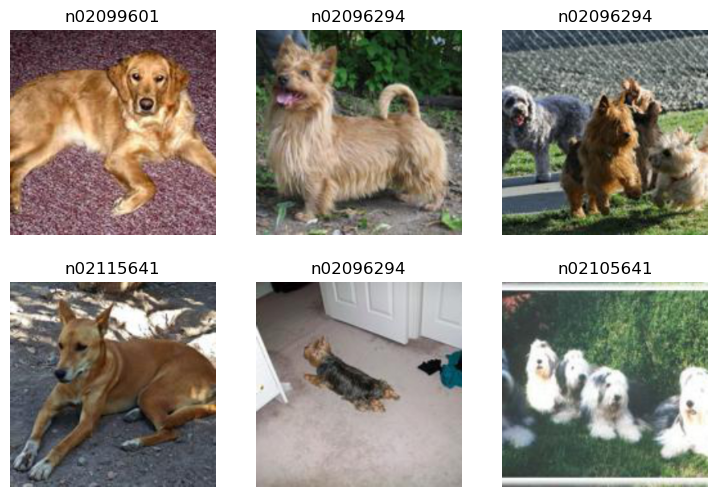

In [7]:
loaders.valid.show_batch(max_n=6, nrows=2)

In [8]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0.1, high=0.9)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")
classification_loss = torch.nn.CrossEntropyLoss()

def mined_loss(miner, loss_func):
    def loss(embeddings, labels):
        mined = miner(embeddings, labels)
        return loss_func(embeddings, labels, mined)
    return loss
  
my_loss = mined_loss(miner = mining_func, loss_func = loss_func)

class CombinedLoss(nn.Module):
    def __init__(self, embed_loss_func, class_loss_func, without_embed=False, without_ce=False):
        super().__init__()
        self.embed_loss_func = embed_loss_func
        self.class_loss_func = class_loss_func
        self.without_embed = without_embed
        self.without_ce = without_ce
    def forward(self, preds, target):
        #embeddings, classifications = preds
        horizontal_embeddings, vertical_embeddings, global_embeddings, classifications = preds
        horizontal_loss = self.embed_loss_func(horizontal_embeddings, target)
        vertical_loss = self.embed_loss_func(vertical_embeddings, target)
        global_loss = self.embed_loss_func(global_embeddings, target)
        class_loss = self.class_loss_func(classifications, target)
        if self.without_embed:
            return class_loss
        elif self.without_ce:
            return horizontal_loss + vertical_loss + global_loss
        else:
            return horizontal_loss + vertical_loss + global_loss + class_loss

combined_loss = CombinedLoss(my_loss, classification_loss)

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[-1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def precision(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return precision_score(targ, pred, average='macro',zero_division=1)

def recall(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return recall_score(targ, pred, average='macro',zero_division=1)

def f1score(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return f1_score(targ, pred, average='macro')

learn=Learner(loaders, 
              model,
              loss_func=combined_loss,
              splitter=siamese_splitter,
              cbs=[ShowGraphCallback],
              metrics=[accuracy,precision,recall,f1score])

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,2.096569,1.583753,0.699228,0.708148,0.692906,0.681853,00:38
1,1.249106,0.866746,0.895753,0.890249,0.892988,0.885744,00:36
2,0.879810,0.715305,0.921622,0.917024,0.917094,0.912543,00:36
3,0.743792,0.674088,0.927799,0.923214,0.923587,0.919772,00:37
4,0.678038,0.670097,0.926641,0.921316,0.922351,0.917781,00:36


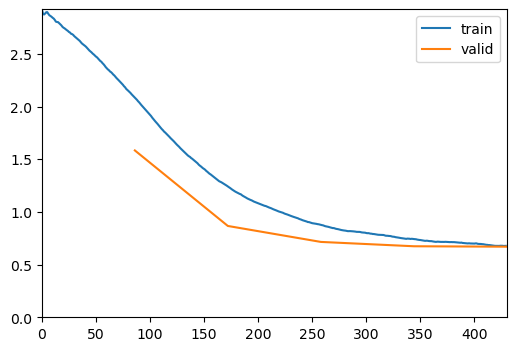

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,0.606503,0.651522,0.932046,0.928142,0.927444,0.924472,00:44
1,0.599087,0.637563,0.938610,0.936108,0.933305,0.931853,00:44
2,0.576534,0.627757,0.943629,0.943498,0.937852,0.937838,00:45
3,0.555333,0.625210,0.945174,0.944947,0.939550,0.938904,00:45
4,0.542858,0.618573,0.947876,0.947548,0.944912,0.943450,00:46
5,0.513538,0.624461,0.947876,0.947867,0.943266,0.942545,00:46
6,0.506068,0.630967,0.946718,0.945642,0.941336,0.940386,00:45
7,0.490900,0.620869,0.950193,0.946835,0.945377,0.943929,00:45
8,0.485846,0.624993,0.950193,0.950736,0.943694,0.943301,00:45
9,0.476087,0.620481,0.949807,0.950001,0.945075,0.944419,00:46


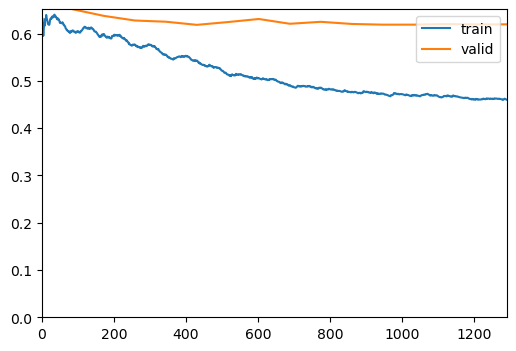

In [10]:
learn.fine_tune(15,freeze_epochs=5)

In [14]:
hooks = Hooks(model.module.encoder if DP else model.encoder, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0])
    hooks_output = nn.Flatten()(hooks.stored[-1])
    hooks_output = hooks_output.to(ftrs.device)  # move hooks_output to the same device as ftrs
    ftrs = torch.cat((ftrs, hooks_output))

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

In [ ]:
from umap import UMAP
umap = UMAP(n_components=2)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')